# Welcome to our Project!

## Goal of This Project: 
### We are continuing working on using regression modeling to make predictions based on our Zillow data of 2017 properties for single family homes. In this itteration of the project we are using clustering algorithms to aid us in determining similarites of the data. We are also shifting our focus to logerror rather than tax value.


## Project Plan
   

### Acquire and Prepare Data
   1. Data is brought in from either the SQL database using a locally stored env file that must contain the username, password, and host name in a get_bd_url function OR via a locally strored csv file.
   2. Data is prepared in order for our team to explore and modified to use in modeling
   3. Data is split into three dataframes called train, validate, and test so that we can train and explore on in-sample data and use out-of-sample to validate and finally test. 

### Exploration
   1. Use visualizations to see patterns in the data and try to determine drivers/indicators of logerror
   2. Use statistical testing, if necessary, to confirm or reject the relationship between features
   3. Use clustering to create new categorical features that can be explored 
   4. Determine what features align with logerror deviating significantly from zero

### Modeling
   1. Take features determined to be significant in exploration
   2. Determine which regression algorithm to use
   3. Run 4 models with chosen features and determine the best one by evaluating the RMSE score on the train set and run on the validate set
   4. The best model will be deterined by lowest RMSE on train, and lowest variance between the RMSE of train and validate
   5. Run the top single model on the test dataset
   6. Evaluate results

### Recommendations / What Comes Next
   1. Based on model evaluation of the test dataset make recommendations and predictions
   2. Recommendations will include...
   3. Further steps are...

### Imports

In [1]:
import wrangle as w
import explore as e
import wrangle_Naomi as wn
import model as m
import env

import pandas as pd
import numpy as np
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans

from importlib import reload
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


## Wrangling the Data (from SQL database using env file or local csv)
### For this we chose to initailly eliminate columns with more than 50% of the values being Null, and rows with anymore than 25% Null values. We also removed 'property county land use code' and 'property zoning desc' as they could not be converted from objects. Any further nulls were imputed with zero. We also made the data more human readable by changing the names of the columns.

In [2]:
#wrangling data and assigning it to a dataframe
df = w.wrangle_zillow()

In [3]:
# splitting data into three dataframes for training, validation, and testing
train, validate, test = w.tvt_split(df)

In [4]:
# shape of the three datasets
w.split_view(train, validate, test)
train_scaled = w.scale(train,['fireplace_count', 'latitude', 'longitude', 'tax_value', 'calc_sqft', 'log_error','pool_count','fips'])

train observations:  (43330, 19)
validate observations:  (18570, 19)
test observations:  (15475, 19)


## Data Dictionary

|**Feature**|**Definition**|**Manipulation**|**Data Type**|
:-|:-|:-:|:-|
|<img width = 50/>|<img width = 50/>|<img width = 50/>|<img width = 50/>|
|*calc_bath_and_bed*| The number of Bathrooms|Name change| float
|*calc_sqft*| The square footage of the property| Name change | float
|*fips* | The code of geographic location| Data Conversion| categorical
|*fireplace_count*|The number of fireplaces on a property| Null values imputed as zero | float
|*garage_car_count*| The number of cars a gargae can hold| Null values imputed as zero| float
|*lot_sqft*| The square footage assigned to a property's exterior| Null values imputed as zero| float
|*pool_count*| The number of pools on a property| Null values imputed as zero| float
|*tax_value*| The dollar amount paid in taxes for the property| | Null values imputed as zero| float


# Exploration
## Our Thought Process:
   1. We began by taking a look at our train dataset in relation to our target vaiable, logerror.
   2. We then look to see what individial features tend to deviate significantly from zero logerror. 
   3. From looking at our features, we were able to generate four specific questions to ask of the data. 
   4. We used our human eyes and computer algorithms to create clusters which were tested against the target variable.
   5. We used visualizations and statistical tests to answer our questions. Sometimes the evaluation and answers lead to further questions. 
   

## Question One:
### Does FIPS code 6059 have a significantly higher log error than the mean of the data set?

#### $H_0$: $\mu_6059 = \mu_{all}$

#### $H_a$: $\mu_6059 \neq \mu_{all}$

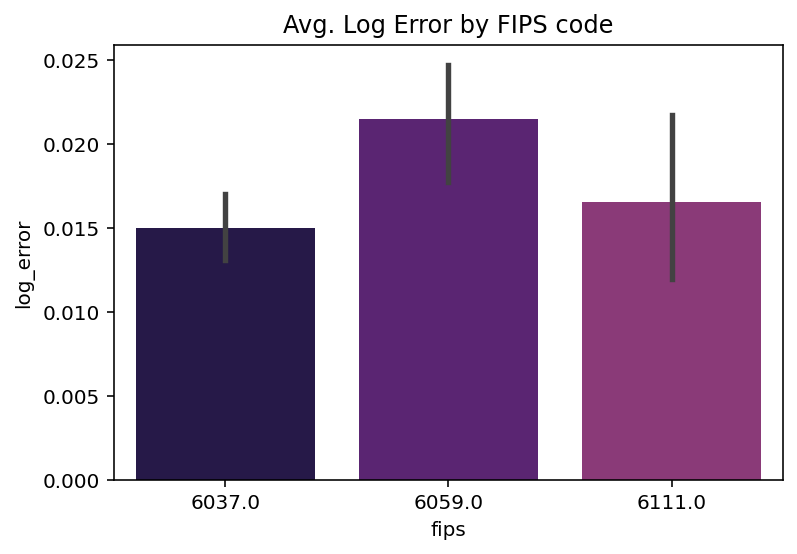

In [5]:
# calls a function that graphs the logerror of the three counties by fips
reload(e)
e.fips_plot(train)

In [6]:
# this function calls a one-sided t-test that tests the means of the train dataset and the mean of fips 6059
reload(e)
e.fips_test(train)

## t = 2.5546094092223135 

 ## p = 0.0106435034574719 

## Because t > 0 and $\alpha$ > p/2, we   reject $H_0$

### Our takeaway, our graph shows us that location is significnat, and our one-sided t-test confims.

## Question Two:
### Can calculated square footage and tax value help predict log error

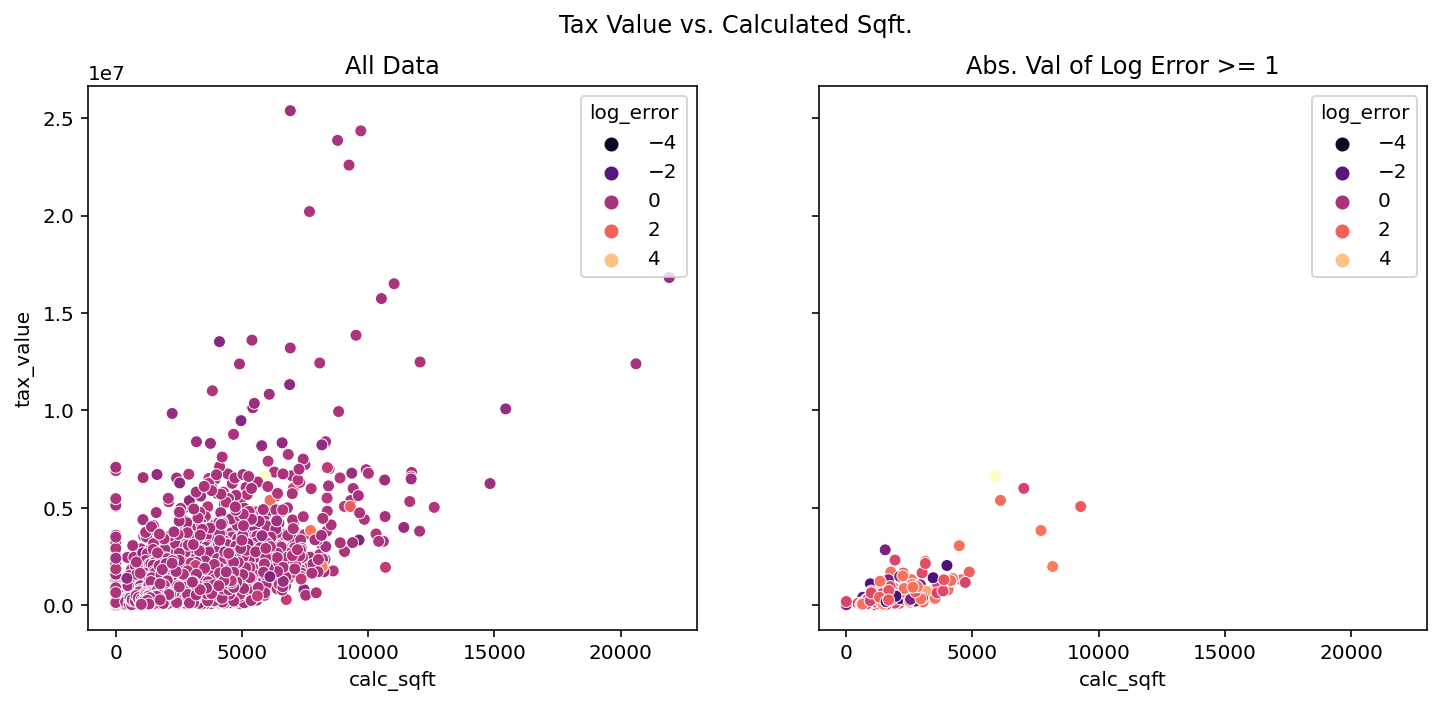

In [7]:
# calls two scatter plots that show which have the highest deviation logerror 
e.tax_sqft_plot(train)

### Based on this graph, we can conclude that there does appear to be a relationship between calculated square footage, tax value, and log errror

## Question Three: 
### Does clustering based on tax value and square footage result in statistically significant differences in each cluster's log error?

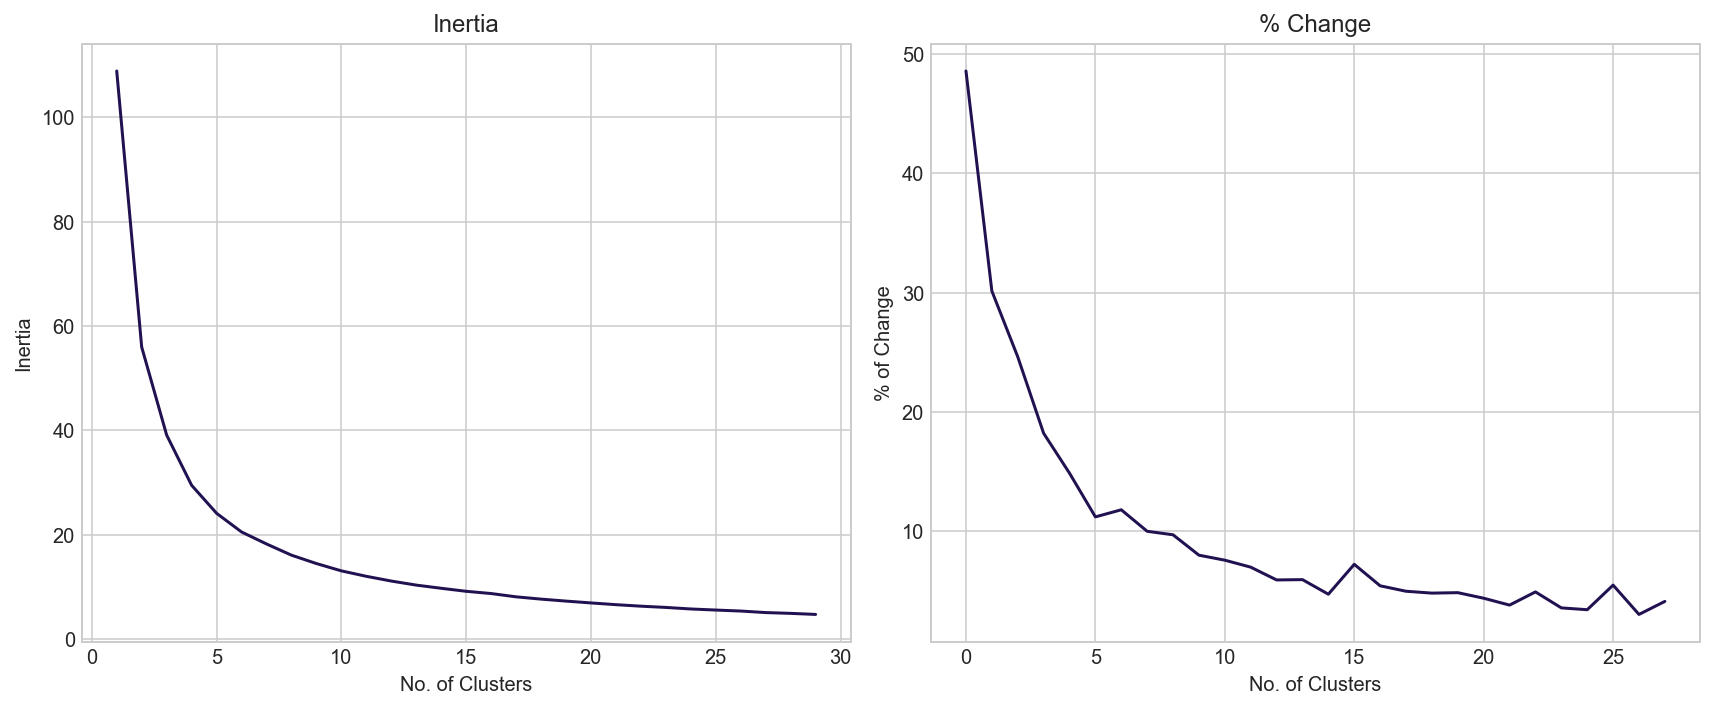

Index(['fireplace_count', 'latitude', 'longitude', 'tax_value', 'calc_sqft',
       'pool_count', 'fips', 'tax_sqft', 'log_error'],
      dtype='object')

In [8]:
reload(e)
train_scaled,scaler,kmeans = m.scale_and_cluster(train,['fireplace_count', 'latitude', 
    'longitude', 'tax_value', 'calc_sqft','pool_count','fips'],cluster_cols=['tax_value','calc_sqft'],cluster_name='tax_sqft',target='log_error',k=5)
e.generate_elbow(train_scaled[['calc_sqft','tax_value']])
train_scaled.columns


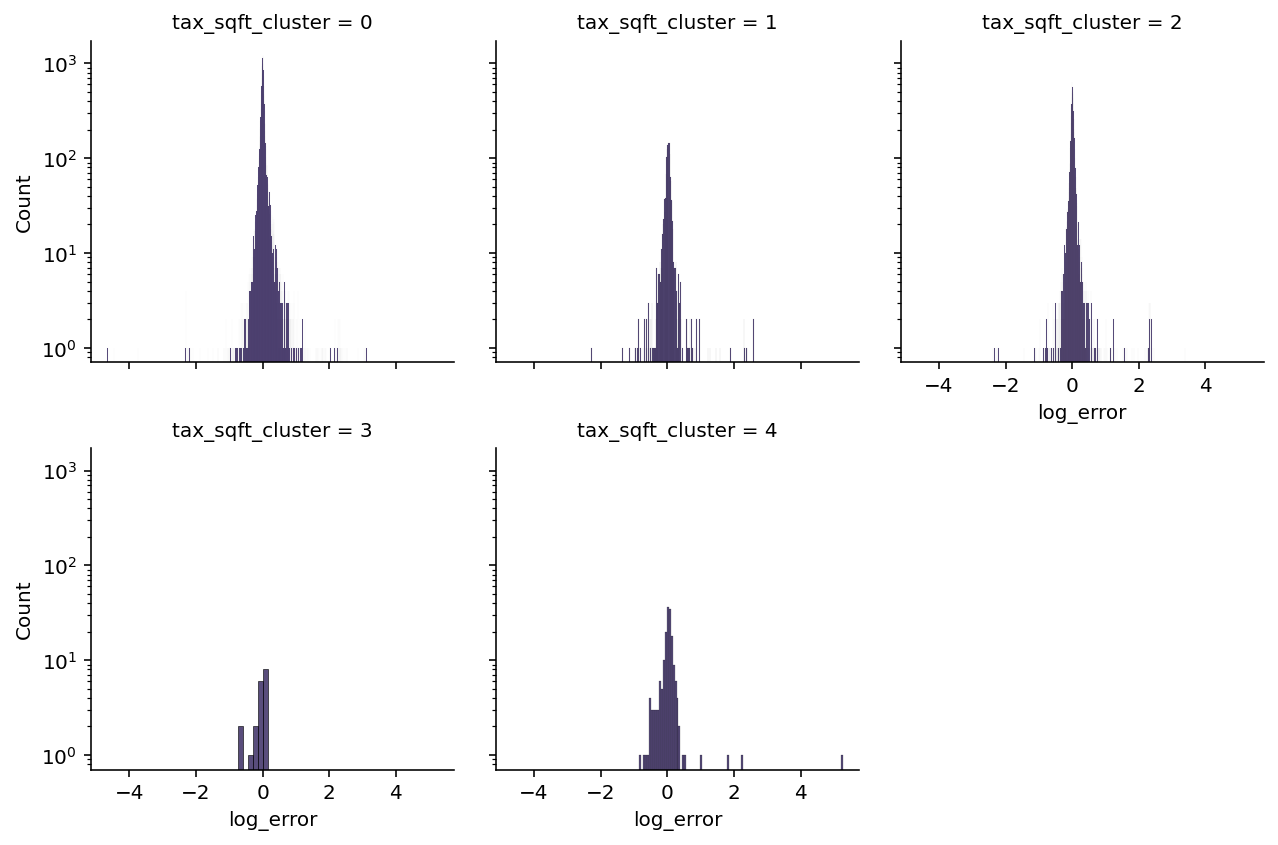

In [9]:
#calls a histograms of five generated clusters consisting of tax value and calculated squarefeet
e.tax_sqft_cluster_plot(train)

# Question: is the mean log_error of items clustered by tax_value and calc_sqft significantly different from each other?

$H_0$: $\mu_{taxsqft0} = \mu_{taxsqft1}=$...$\mu_{taxsqft7}$

$H_a$: $\mu_{taxsqft0} \neq \mu_{taxsqft1} \neq $...$\neq \mu_{taxsqft7}$

## Assumptions
- Independent: Yep
- Normal: yes, Central Limit Theorum
- Equal variance:

In [10]:
train['tax_sqft_cluster'] = train_scaled.tax_sqft
train.groupby('tax_sqft_cluster').agg('var')[['log_error']]


,log_error
tax_sqft_cluster,
0,0.027555
1,0.062548
2,0.031776
3,0.067728
4,0.251718


In [11]:
samples = [train[train.tax_sqft_cluster == i].log_error for i in range(5)]
t,p = stats.levene(samples[0],samples[1],samples[2],samples[3],samples[4])
e.p_to_md(p,t)

## Because $\alpha$ > p,we  reject $H_0$

<div class="alert alert-block alert-info">
<b>Note: </b> Because the ranges of variance are so wide, we will use the non-parametric test
</div>

In [12]:
group_list = [train[train.tax_sqft_cluster == x].log_error.to_numpy() for x in range(4)]
t,p = stats.f_oneway(group_list[0],group_list[1],group_list[2],group_list[3])
e.t_to_md(t,p)

## t = 0.0018899087994636132 

 ## p = 4.972782816437675 

## Because t > 0 and $\alpha$ < p, we failed to   reject $H_0$

<div class="alert alert-block alert-success">
<b>Moving Forward</b> However, given that there is such a strong cluster of these values based on tax value and square footage, we will move forward with the clusters as regression models
</div>

## Question Four:
### Will making a cluster of what my human eyes determine to be valuable out-door features help determine houses with significantly higher or lower logerror?

#### Valuable out-door features are garage count, pool count, and lot size

In [13]:
# creates a scaled dataframe with the features, garage car count, pool count, and lot squarefeet
# all nan values are imputed as zero
train_scaled3 = e.scaled_3(train)

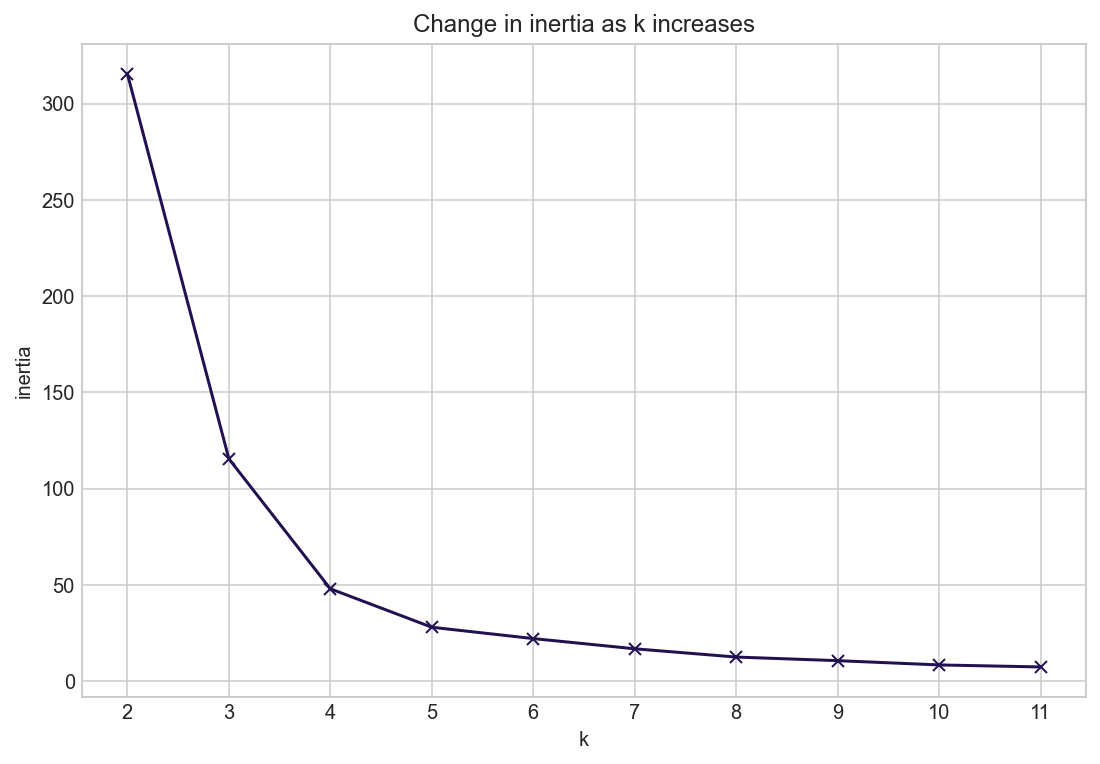

In [14]:
# displays graph to show optimal number of clusters
e.elbow_for_Q3(train_scaled3)

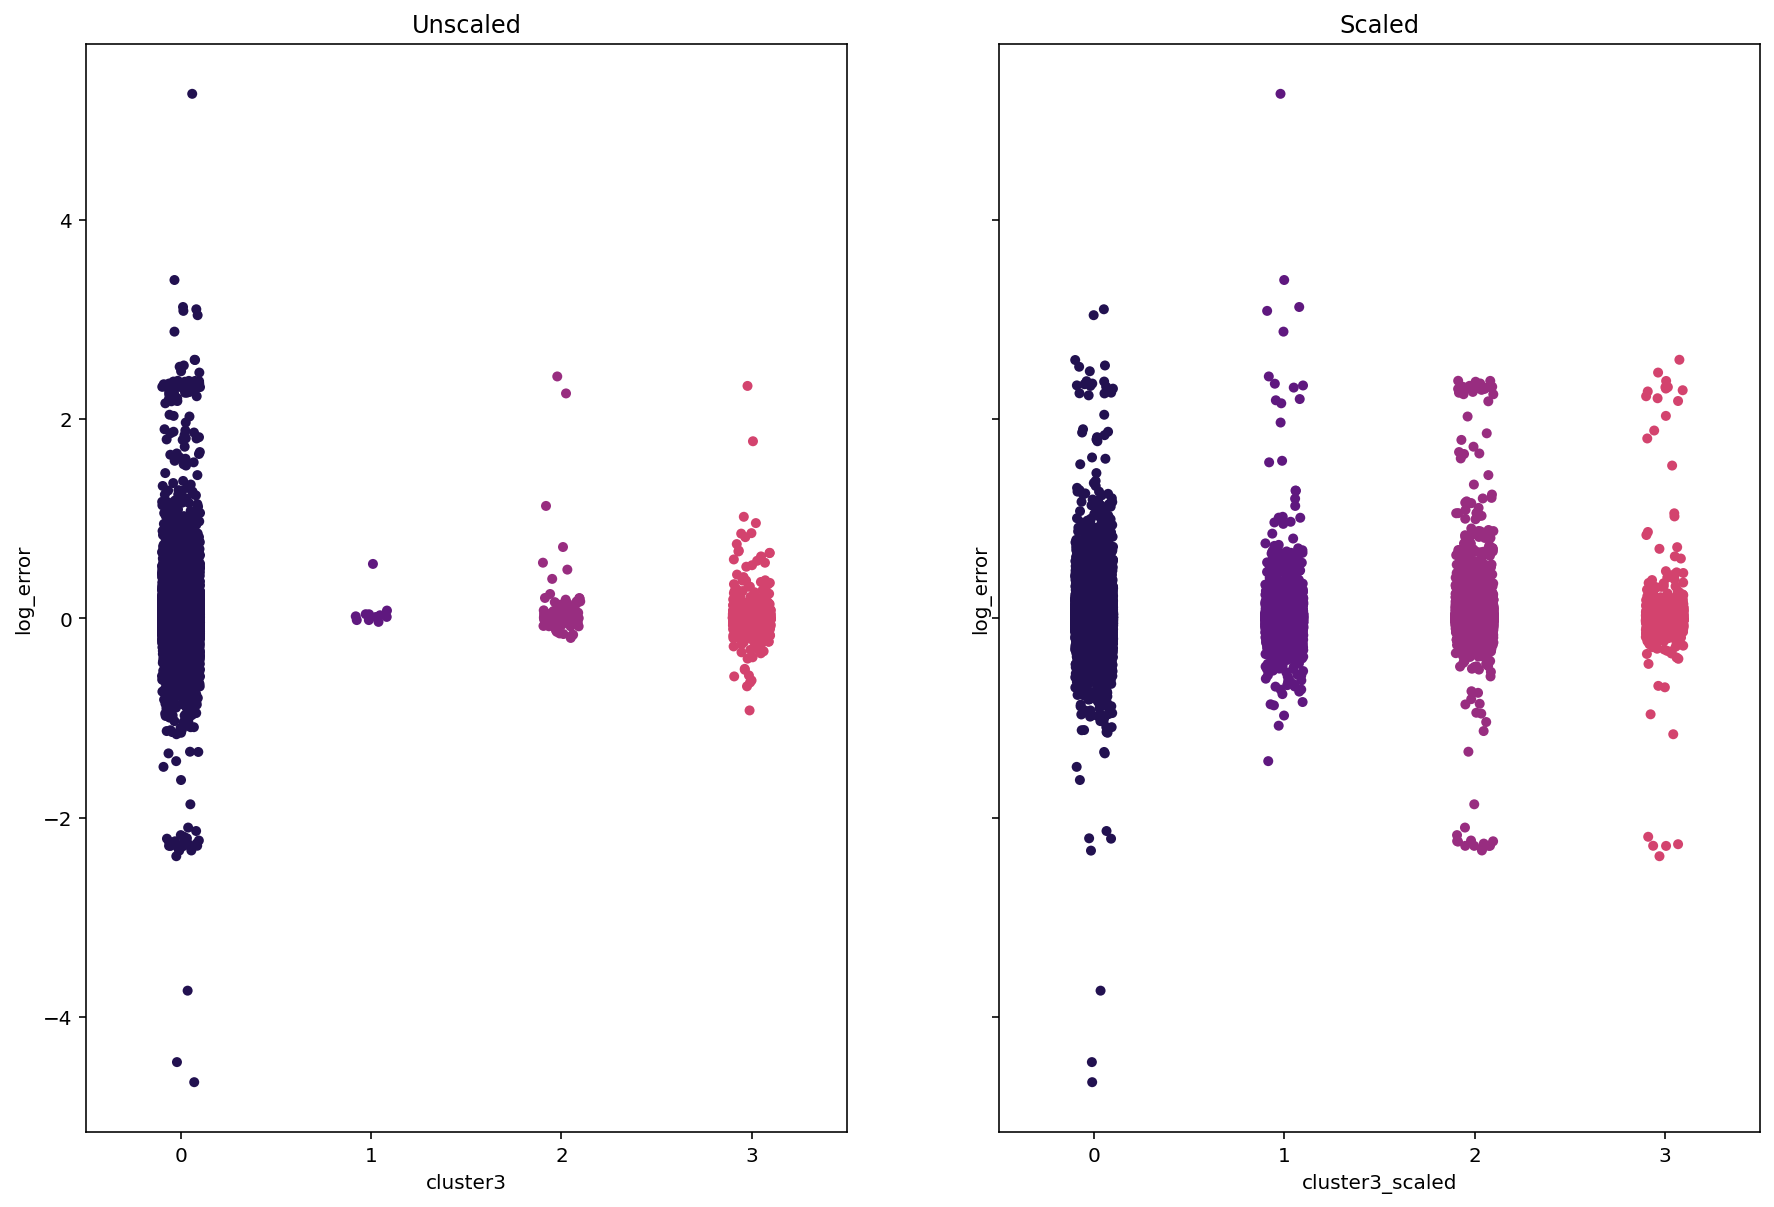

In [15]:
# compares two strip plots of scaled and unsclaed cluster data
e.viz_for_Q3(train)

In [16]:
# stat test for unscaled data
e.anova_test(train, 'cluster3')

## t = 0.12168643873344878 

 ## p = 5.801327910069646 

## Because t > 0 and $\alpha$ < p, we failed to   reject $H_0$

In [17]:
#stat test for scaled data
e.anova_test(train_scaled3, 'cluster3_scaled')

## t = 8.296902485164197e-10 

 ## p = 45.22280000852593 

## Because t > 0 and $\alpha$ < p, we failed to   reject $H_0$

<div class="alert alert-block alert-danger">
<b>  Takeaway:
    Based on the anova test we must conceed that there is no relationship between the cluster of features and log error, and that my human intuition is useless. 
</div>

# Modeling

### Moving forward in our modeling we chose to use tax value and calculated square feet as a clustered feature, along with the features fireplace count, latitude, and longitude. We chose to include these in our model because all six features showed to consistently coincide with having clusters that were both centered around zero logerror as well as having wide variance away from zero logerror. We chose to use tax value and calculated square feet as a cluster because together they showed the most centralized cluster around zero with the fewest significant outliers.

## Modeling Pre-Processing
   1. First we decided what features would move into our model.
      * we chose to use tax value and calculated square feet as a clustered feature, along with the features fireplace count, latitude, and longitude.
      * We chose to use tax value and calculated square feet as a cluster because together they showed the most centralized cluster around zero with the fewest significant outliers.
   2. We ensured all of our data was numerical
   3. We split our train, validate, and test data sets to seperate the target variable of logerror to use as y- train, validate, and test.
  

In [18]:
# displays mean and median for baseline logerror
md,baseline = m.select_baseline(train.log_error)
md

|                 |     SSE |       MSE |     RMSE |
|:----------------|--------:|----------:|---------:|
| Mean Baseline   | 1334.4  | 0.0307963 | 0.175489 |
| Median Baseline | 1338.71 | 0.0308956 | 0.175772 |
### Because mean outperformed median on all metrics,         we will use mean as our baseline

### We Used 3 Regression Models on Train and Validate To Determine Which to Use on Our Test Data

In [19]:
# Seperates x and y for train, validate, and test sets. 
#runs three regression models on train, validate, and test sets
# displays dataframe with results for all six tests as well as baseline errors
train_validate_errors,scaler,kmeans,regressors = m.train_and_validate_errors(train,validate)
pd.concat([baseline,train_validate_errors])

,SSE,MSE,RMSE,ESS,TSS
Mean Baseline,1334.401766,0.030796,0.175489,NaN,NaN
TweedieRegressor train,1334.380068,0.030796,0.175487,6.019596e-04,1334.380669
TweedieRegressor validate,496.447831,0.026734,0.163505,3.936859e-02,496.487200
LASSO+LARS train,1334.401766,0.030796,0.175489,6.310947e-29,1334.401766
LASSO+LARS validate,496.455857,0.026734,0.163506,3.766486e-02,496.493522
LinearRegression train,1334.111938,0.030790,0.175470,2.898275e-01,1334.401766
LinearRegression validate,496.325344,0.026727,0.163485,1.605952e-01,496.485939


<div class="alert alert-block alert-info">
<b>Evaluation:</b> Based on the resulting RMSE between the train and validate sets, we decided to use Linear Regression on our test set because the train RMSE is lower than baseline, and the difference between the train and validate does not hint at overfitting.
</div>

In [20]:
# Finally, test set is run on linear regression model
m.test_errors(test,scaler,kmeans,regressors)

,SSE,ESS,TSS,MSE,RMSE
Test Predictions,410.079874,0.224869,410.304744,0.0265,0.162787


<div class="alert alert-block alert-warning">
<b>Conclusion:</b> Our model run on the test data results in RMSE score that is 12% lower than baseline
</div>

# Takeaways and Recommendations

####  Based on our analysis and modeling:
* Our model performed better than baseline on the data, but we are still not happy with it
* We feel that the amount of nulls in the original data leads to skewed results due to being able to use limited features
* Future itterations of this project should include a more focused plan, and more time to explore relationships between features
* We conclude that clustering can be a useful tool in finding unseen patterns in the data, but more time would be appreciated to fully dive into how this method could improve predictions